# Pokedex modelling

In this notebook, I'll be trying to make a computer vision model able to recognize among [50 of the most used Pokemons in OverUsed](https://www.pikalytics.com/pokedex/gen8ou) to be able to recognize them during battles, and quickly get data about this pokemon with the other part of this project.

This modelling process was really tricky for two reasons :

* As I didn't have access to my laptop for a long period, I had to code on my phone, on Colab. (that's why all my experiments don't appear, as I kept on modifying the same cell over and over until I had satisfying result)
* The data was rare. For every class, the number of available pictures varies from 15 to 60. It's obviously super low and, even though I tried going with a CNN and had a satisfying result (85%), I discovered how to mix deep learning and random forests to handle that lack of data

## Getting data ready

The first step was to turn all of the data into two train and test datasets. Fortunately, [this script](https://stackoverflow.com/questions/57394135/split-image-dataset-into-train-test-datasets) was definitely helpful for that

In [2]:
# https://stackoverflow.com/questions/57394135/split-image-dataset-into-train-test-datasets

import os
import shutil
import numpy as np
import argparse

def get_files_from_folder(path):
    files = os.listdir(path)
    return np.asarray(files)

def edit_files(path_to_data, path_to_test_data, train_ratio):
    # get dirs
    _, dirs, _ = next(os.walk(path_to_data))

    # calculates how many train data per class
    data_counter_per_class = np.zeros((len(dirs)))
    for i in range(len(dirs)):
        path = os.path.join(path_to_data, dirs[i])
        files = get_files_from_folder(path)
        data_counter_per_class[i] = len(files)
    test_counter = np.round(data_counter_per_class * (1 - train_ratio))

    # transfers files
    for i in range(len(dirs)):
        path_to_original = os.path.join(path_to_data, dirs[i])
        path_to_save = os.path.join(path_to_test_data, dirs[i])

        #creates dir
        if not os.path.exists(path_to_save):
            os.makedirs(path_to_save)
        files = get_files_from_folder(path_to_original)
        # moves data
        for j in range(int(test_counter[i])):
            dst = os.path.join(path_to_save, files[j])
            src = os.path.join(path_to_original, files[j])
            shutil.move(src, dst)


edit_files("/content/drive/MyDrive/data/PokemonData", "/content/drive/MyDrive/data/PokemonData/test_data/", 0.85)

# # And then we move the train files into a fresh directory, and think about removing the test_data folder generated in the test_data

In [29]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
import pathlib
import numpy as np
data_dir = pathlib.Path("PokemonData/train_data") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
class_names, len(class_names)

(array(['aegislash', 'alakazam', 'bisharp', 'blacephalon', 'blissey',
        'buzzwole', 'chansey', 'charizard', 'clefable', 'corviknight',
        'crawdaunt', 'dragapult', 'dragonite', 'excadrill', 'ferrothorn',
        'garchomp', 'hawlucha', 'heatran', 'hippowdon', 'hydreigon',
        'kartana', 'kommo-o', 'kyurem', 'landorus-therian', 'lucario',
        'magnezone', 'melmetal', 'mew', 'moltres-galar', 'nidoking',
        'pelipper', 'rillaboom', 'rotom-wash', 'scizor', 'skarmory',
        'tangrowth', 'tapu fini', 'tapu koko', 'tapu lele', 'torkoal',
        'tornadus-therian', 'toxapex', 'tyranitar', 'urshifu', 'victini',
        'volcarona', 'weavile', 'zapdos', 'zapdos-galar', 'zeraora'],
       dtype='<U16'),
 50)

In [74]:
#View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_image(index_class_name):
    target_folder = f"PokemonData/train_data/{class_names[index_class_name]}"
    
    random_image = random.sample(os.listdir(target_folder), 1) #Select a random image from the selected directory
    
    # Read the image
    img = mpimg.imread(target_folder+"/"+random_image[0])
    plt.figure(figsize=(7, 7))
    plt.imshow(img)
    plt.title(class_names[index_class_name])
    plt.axis("off")
    
    # Print stats
    print(f"Image shape: {img.shape}\n\n")
    print(img[0][:3])

Image shape: (300, 236, 3)


[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


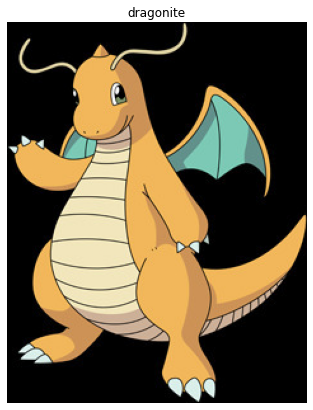

In [95]:
random_number = random.randint(0, 50)

view_image(random_number)

In [3]:
train_dir = "PokemonData/train_data/"
test_dir= "PokemonData/test_data/"

In [4]:
# Create train and test data generators and rescale the data 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=(200, 200),
                                               class_mode='binary',
                                               batch_size=32)

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=(200, 200),
                                             class_mode='binary',
                                             batch_size=32)

Found 2574 images belonging to 50 classes.
Found 205 images belonging to 50 classes.


## Getting helper functions for modelling

In [5]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [14]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

## First model : pure CNN

Using a low enough learning rate, ReduceLROnPlateau and Early Stopping I managed to find a way of getting a good result with CNN, despite my lack of data

In [2]:
import tensorflow as tf
from tensorflow.keras import layers

In [9]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=10)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=4,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [15]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="model_checkpoints/cp_test.ckpt",
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor="val_accuracy",
                                                 verbose=1)
test = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3, # can also be (3, 3)
                         activation="relu",input_shape=(200, 200, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(2),
    layers.Dropout(0.5),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(len(class_names), activation="softmax")
])

# Compile the model
test.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007),
              metrics=["accuracy"])

# Fit the model
test_history = test.fit(train_data,
                        epochs=150,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks=[create_tensorboard_callback("tensorboard", "baseline"),
                                   early_stopping,
                                   reduce_lr,
                                  cp_callback])

Saving TensorBoard log files to: tensorboard/baseline/20220102-165140
Epoch 1/150
81/81 [==============================] - ETA: 0s - loss: 3.8897 - accuracy: 0.0326
Epoch 00001: val_accuracy improved from -inf to 0.03902, saving model to model_checkpoints\cp_test.ckpt
81/81 [==============================] - 36s 436ms/step - loss: 3.8897 - accuracy: 0.0326 - val_loss: 3.8392 - val_accuracy: 0.0390 - lr: 7.0000e-04
Epoch 2/150
81/81 [==============================] - ETA: 0s - loss: 3.7995 - accuracy: 0.0400
Epoch 00002: val_accuracy did not improve from 0.03902
81/81 [==============================] - 36s 446ms/step - loss: 3.7995 - accuracy: 0.0400 - val_loss: 3.6349 - val_accuracy: 0.0390 - lr: 7.0000e-04
Epoch 3/150
81/81 [==============================] - ETA: 0s - loss: 3.5268 - accuracy: 0.0917
Epoch 00003: val_accuracy improved from 0.03902 to 0.13659, saving model to model_checkpoints\cp_test.ckpt
81/81 [==============================] - 36s 450ms/step - loss: 3.5268 - accuracy

Epoch 25/150
81/81 [==============================] - ETA: 0s - loss: 1.1716 - accuracy: 0.6554
Epoch 00025: val_accuracy did not improve from 0.76098
81/81 [==============================] - 36s 447ms/step - loss: 1.1716 - accuracy: 0.6554 - val_loss: 1.3387 - val_accuracy: 0.7171 - lr: 7.0000e-04
Epoch 26/150
81/81 [==============================] - ETA: 0s - loss: 1.1742 - accuracy: 0.6535
Epoch 00026: val_accuracy did not improve from 0.76098
81/81 [==============================] - 38s 466ms/step - loss: 1.1742 - accuracy: 0.6535 - val_loss: 1.1269 - val_accuracy: 0.7366 - lr: 7.0000e-04
Epoch 27/150
81/81 [==============================] - ETA: 0s - loss: 1.1232 - accuracy: 0.6643
Epoch 00027: val_accuracy did not improve from 0.76098
81/81 [==============================] - 36s 447ms/step - loss: 1.1232 - accuracy: 0.6643 - val_loss: 1.0915 - val_accuracy: 0.7610 - lr: 7.0000e-04
Epoch 28/150
81/81 [==============================] - ETA: 0s - loss: 1.0401 - accuracy: 0.6896
Epoc

Epoch 51/150
81/81 [==============================] - ETA: 0s - loss: 0.5349 - accuracy: 0.8419
Epoch 00051: val_accuracy improved from 0.84390 to 0.85366, saving model to model_checkpoints\cp_test.ckpt
81/81 [==============================] - 36s 447ms/step - loss: 0.5349 - accuracy: 0.8419 - val_loss: 1.0759 - val_accuracy: 0.8537 - lr: 1.4000e-04
Epoch 52/150
81/81 [==============================] - ETA: 0s - loss: 0.5295 - accuracy: 0.8302
Epoch 00052: ReduceLROnPlateau reducing learning rate to 2.7999997837468984e-05.

Epoch 00052: val_accuracy did not improve from 0.85366
81/81 [==============================] - 36s 447ms/step - loss: 0.5295 - accuracy: 0.8302 - val_loss: 1.0964 - val_accuracy: 0.8488 - lr: 1.4000e-04
Epoch 53/150
81/81 [==============================] - ETA: 0s - loss: 0.5175 - accuracy: 0.8388
Epoch 00053: val_accuracy did not improve from 0.85366
81/81 [==============================] - 36s 443ms/step - loss: 0.5175 - accuracy: 0.8388 - val_loss: 1.1000 - val_

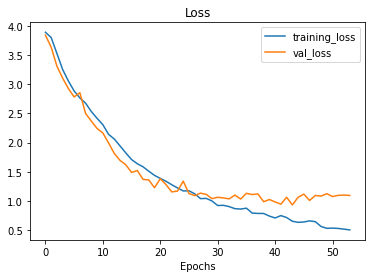

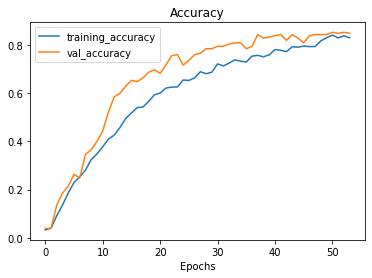

In [16]:
plot_loss_curves(test_history)

In [17]:
# model.load_weights("model_checkpoints/cp.ckpt")
# model.evaluate(test_data)

In [2]:
import tensorflow as tf

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10,
                         kernel_size=3,
                         activation="relu",input_shape=(200, 200, 3)),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2,
                            padding="valid"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(50, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007),
              metrics=["accuracy"])

In [3]:
model.load_weights("model_checkpoints/cp.ckpt")

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1/255.)
test_data = test_datagen.flow_from_directory(directory="PokemonData/test_data/",
                                             target_size=(200, 200),
                                             class_mode='binary',
                                             batch_size=32)

Found 205 images belonging to 50 classes.


In [4]:
preds = model.evaluate(test_data)

7/7 [==============================] - 3s 359ms/step - loss: 1.0759 - accuracy: 0.8537


In [5]:
preds

[1.0758551359176636, 0.8536585569381714]

## Combining Deep Learning and machine learning

While scrolling YouTube to find an interesting data science video, I came across [this video](https://www.youtube.com/watch?v=9GzfUzJeyi0) explaining how to take the features of a CNN into a random forest to better handle low data. The vast majority of the code below is taken from the video, except the data augmentation to get a bit more generalization.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization
import os
import seaborn as sns

In [2]:
print(os.listdir("PokemonData/train_data/"))

['aegislash', 'alakazam', 'bisharp', 'blacephalon', 'blissey', 'buzzwole', 'chansey', 'charizard', 'clefable', 'corviknight', 'crawdaunt', 'dragapult', 'dragonite', 'excadrill', 'ferrothorn', 'garchomp', 'hawlucha', 'heatran', 'hippowdon', 'hydreigon', 'kartana', 'kommo-o', 'kyurem', 'landorus-therian', 'lucario', 'magnezone', 'melmetal', 'mew', 'moltres-galar', 'nidoking', 'pelipper', 'rillaboom', 'rotom-wash', 'scizor', 'skarmory', 'tangrowth', 'tapu fini', 'tapu koko', 'tapu lele', 'torkoal', 'tornadus-therian', 'toxapex', 'tyranitar', 'urshifu', 'victini', 'volcarona', 'weavile', 'zapdos', 'zapdos-galar', 'zeraora']


In [3]:
SIZE = 200

In [21]:
train_images = []
train_labels = [] 

for dirpath, dirnames, filenames in os.walk("PokemonData\\train_data"):
    if filenames != []:
        for file in filenames:
            img = cv2.imread(dirpath+"\\"+ file, cv2.IMREAD_COLOR)
            img = cv2.resize(img, (SIZE,SIZE))
            train_images.append(img)
            train_labels.append(dirpath.split("\\")[-1])

print(train_labels[:5])

['aegislash', 'aegislash', 'aegislash', 'aegislash', 'aegislash']


In [22]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [23]:
test_images = []
test_labels = [] 

for dirpath, dirnames, filenames in os.walk("PokemonData\\test_data"):
    if filenames != []:
        for file in filenames:
            img = cv2.imread(dirpath+"\\"+ file, cv2.IMREAD_COLOR)
            img = cv2.resize(img, (SIZE,SIZE))
            test_images.append(img)
            test_labels.append(dirpath.split("\\")[-1])
print(test_labels[:5])

['aegislash', 'aegislash', 'aegislash', 'aegislash', 'alakazam']


In [24]:
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [25]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [26]:
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [27]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [28]:
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [43]:
import tensorflow as tf
cp_rl = tf.keras.callbacks.ModelCheckpoint(filepath="model_checkpoints/cp_rl.ckpt",
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor="val_accuracy",
                                                 verbose=1)

In [76]:
from tensorflow.keras import layers
activation = 'sigmoid'

feature_extractor = Sequential()
feature_extractor.add(layers.Input(shape=(200,200,3)))
feature_extractor.add(layers.RandomFlip("horizontal"))
feature_extractor.add(layers.RandomRotation(0.1))
feature_extractor.add(layers.RandomContrast(0.1))
feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', input_shape = (SIZE, SIZE, 3)))
feature_extractor.add(BatchNormalization())

feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Flatten())

In [77]:
x = feature_extractor.output  
x = Dense(128, activation = activation, kernel_initializer = 'he_uniform')(x)
prediction_layer = Dense(50, activation = 'softmax')(x)

In [78]:
cnn_model = Model(inputs=feature_extractor.input, outputs=prediction_layer)
cnn_model.compile(optimizer='rmsprop',loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [79]:
history = cnn_model.fit(x_train, y_train_one_hot, epochs=50, validation_data = (x_test, y_test_one_hot), callbacks=[cp_rl])

Epoch 1/50
41/41 [==============================] - ETA: 0s - loss: 4.0536 - accuracy: 0.0328
Epoch 00001: val_accuracy did not improve from 0.10244
41/41 [==============================] - 87s 2s/step - loss: 4.0536 - accuracy: 0.0328 - val_loss: 4.0386 - val_accuracy: 0.0390
Epoch 2/50
41/41 [==============================] - ETA: 0s - loss: 3.8265 - accuracy: 0.0610
Epoch 00002: val_accuracy did not improve from 0.10244
41/41 [==============================] - 85s 2s/step - loss: 3.8265 - accuracy: 0.0610 - val_loss: 4.1201 - val_accuracy: 0.0390
Epoch 3/50
41/41 [==============================] - ETA: 0s - loss: 3.7705 - accuracy: 0.0641
Epoch 00003: val_accuracy did not improve from 0.10244
41/41 [==============================] - 87s 2s/step - loss: 3.7705 - accuracy: 0.0641 - val_loss: 4.0531 - val_accuracy: 0.0390
Epoch 4/50
41/41 [==============================] - ETA: 0s - loss: 3.7220 - accuracy: 0.0702
Epoch 00004: val_accuracy did not improve from 0.10244
41/41 [==========

Epoch 30/50
41/41 [==============================] - ETA: 0s - loss: 3.0139 - accuracy: 0.1930
Epoch 00030: val_accuracy did not improve from 0.20976
41/41 [==============================] - 84s 2s/step - loss: 3.0139 - accuracy: 0.1930 - val_loss: 3.1229 - val_accuracy: 0.1707
Epoch 31/50
41/41 [==============================] - ETA: 0s - loss: 2.9049 - accuracy: 0.2105
Epoch 00031: val_accuracy did not improve from 0.20976
41/41 [==============================] - 85s 2s/step - loss: 2.9049 - accuracy: 0.2105 - val_loss: 3.0740 - val_accuracy: 0.1561
Epoch 32/50
41/41 [==============================] - ETA: 0s - loss: 2.9124 - accuracy: 0.2166
Epoch 00032: val_accuracy did not improve from 0.20976
41/41 [==============================] - 84s 2s/step - loss: 2.9124 - accuracy: 0.2166 - val_loss: 2.9896 - val_accuracy: 0.2049
Epoch 33/50
41/41 [==============================] - ETA: 0s - loss: 2.9315 - accuracy: 0.2342
Epoch 00033: val_accuracy did not improve from 0.20976
41/41 [======

In [80]:
X_for_RF = feature_extractor.predict(x_train)

In [81]:
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 75, random_state = 42)

In [82]:
RF_model.fit(X_for_RF, y_train)

RandomForestClassifier(n_estimators=75, random_state=42)

In [83]:
X_test_feature = feature_extractor.predict(x_test)

In [84]:
prediction_RF = RF_model.predict(X_test_feature)
prediction_RF = le.inverse_transform(prediction_RF)
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))

Accuracy =  0.8439024390243902


In [85]:
import joblib
joblib.dump(RF_model, "./random_forest.joblib", compress=3)

['./random_forest.joblib']